# US Traffic Accidents

According to the Centers for Disease Control and Prevention (CDC), motor vehicle crashes are a leading cause of death in the United States. In fact, in 2020, there were 38,824 deaths due to motor vehicle crashes, which accounted for over 10% of all deaths in the country. While significant progress has been made in reducing the number of deaths due to motor vehicle crashes over the years, there is still much work to be done to improve road safety and reduce the number of preventable deaths.

Thus, in this notebook, we will try to understand the factors that lead to accidents, and also those that affect accident severity

Then, we'll develop ML models to predict accident severity

## PySpark

In [1]:
import pyspark
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
import sys, os

sc = SparkContext() # entry point to Spark programming with RDD
spark = SparkSession(sc) # entry point to Spark programming with DataFrame and Dataset

In [2]:
# Read CSV and header
US_Accidents = spark.read.format("csv").option("header", "true").load("US_Accidents_Dec21_updated.csv")
print("No of rows is ",US_Accidents.count())

No of rows is  2845342


We see that the data set has almost <b>3 million rows</b>. 

Thus, this notebook will show how to deal with <b>Big Data</b> using <i>PySpark</i>

### EDA

In [3]:
# A prettier view of data

def display_spark_df(df, n=5):
    # convert PySpark DataFrame to Pandas DataFrame
    pdf = df.limit(n).toPandas()
    # display the Pandas DataFrame
    print(pdf)

display_spark_df(US_Accidents)

    ID Severity           Start_Time             End_Time           Start_Lat  \
0  A-1        3  2016-02-08 00:37:08  2016-02-08 06:37:08  40.108909999999995   
1  A-2        2  2016-02-08 05:56:20  2016-02-08 11:56:20            39.86542   
2  A-3        2  2016-02-08 06:15:39  2016-02-08 12:15:39            39.10266   
3  A-4        2  2016-02-08 06:51:45  2016-02-08 12:51:45  41.062129999999996   
4  A-5        3  2016-02-08 07:53:43  2016-02-08 13:53:43           39.172393   

            Start_Lng             End_Lat             End_Lng  \
0           -83.09286            40.11206           -83.03187   
1            -84.0628            39.86501           -84.04873   
2           -84.52468  39.102090000000004           -84.52396   
3           -81.53784            41.06217  -81.53546999999998   
4  -84.49279200000002           39.170476          -84.501798   

          Distance(mi)                                        Description  \
0                 3.23  Between Sawmill Rd/Ex

In [4]:
US_Accidents.columns

['ID',
 'Severity',
 'Start_Time',
 'End_Time',
 'Start_Lat',
 'Start_Lng',
 'End_Lat',
 'End_Lng',
 'Distance(mi)',
 'Description',
 'Number',
 'Street',
 'Side',
 'City',
 'County',
 'State',
 'Zipcode',
 'Country',
 'Timezone',
 'Airport_Code',
 'Weather_Timestamp',
 'Temperature(F)',
 'Wind_Chill(F)',
 'Humidity(%)',
 'Pressure(in)',
 'Visibility(mi)',
 'Wind_Direction',
 'Wind_Speed(mph)',
 'Precipitation(in)',
 'Weather_Condition',
 'Amenity',
 'Bump',
 'Crossing',
 'Give_Way',
 'Junction',
 'No_Exit',
 'Railway',
 'Roundabout',
 'Station',
 'Stop',
 'Traffic_Calming',
 'Traffic_Signal',
 'Turning_Loop',
 'Sunrise_Sunset',
 'Civil_Twilight',
 'Nautical_Twilight',
 'Astronomical_Twilight']

We have 47 columns, now lets consider what group these columns belong to generally :

1) Extent of accident - 'Severity'

2) Accident Time - 'Start_Time', 'End_Time' , 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'Timezone'

3) Location Details - 'Start_Lat', 'Start_Lng','End_Lat', 'End_Lng', 'Distance(mi)', 'Number', 'Street', 'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Airport_Code','Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',

4) Weather - 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition'

5) Text Description - 'Description'

Based on the above, we could perhaps analyze the time, location, weather at which most accidents happen, as well as the severity of these accidents

### Accident count by Time

#### Action

In [5]:
US_Accidents.select(['Start_Time']).describe().show()

+-------+-------------------+
|summary|         Start_Time|
+-------+-------------------+
|  count|            2845342|
|   mean|               null|
| stddev|               null|
|    min|2016-01-14 20:18:33|
|    max|2021-12-31 23:30:00|
+-------+-------------------+



We need to get from timestamp only hours since they are likely to explain time of accidents better

In [6]:
from pyspark.sql import functions as F
from pyspark.sql.functions import *

US_Accidents = US_Accidents.withColumn('Start_hour', date_format('Start_Time', 'HH'))

In [7]:
accidents_by_time = US_Accidents.groupBy('Start_hour')

#### Result :

In [8]:
accidents_by_time = accidents_by_time.count().sort("count",ascending=False)
accidents_by_time.show()

+----------+------+
|Start_hour| count|
+----------+------+
|        17|220358|
|        16|218385|
|        15|214264|
|        14|191480|
|        18|168982|
|        13|166473|
|        12|143715|
|        07|135191|
|        08|130879|
|        19|116911|
|        11|113271|
|        06|111160|
|        09|108779|
|        10|103926|
|        20| 94682|
|        21| 87078|
|        22| 81188|
|        05| 80303|
|        23| 74243|
|        00| 68800|
+----------+------+
only showing top 20 rows



Let's plot this on a graph

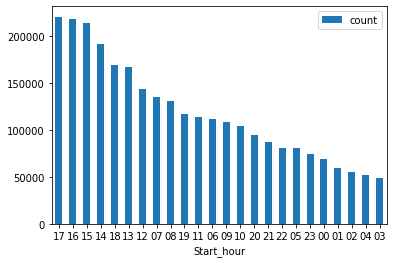

In [9]:
import matplotlib.pyplot as plt

# Convert the PySpark DataFrame to a Pandas DataFrame
accidents_by_time_pd = accidents_by_time.toPandas()

# Plot the bar graph
accidents_by_time_pd.index = accidents_by_time_pd['Start_hour']
accidents_by_time_pd[['count']].plot(kind='bar')
plt.xticks(rotation=0)

# Show the plot
plt.show()

#### Insight : 

Maximum accidents occur between 15-17 i.e. 3-5 pm. 

This makes sense intuitively, as that is the time employees leave for the day

### Severity vs Temperature analysis

We now try to analyze if Temperature has any impact on severity of accident

#### Action

In [10]:
#In PySpark, every column is String by Default ; thus we need to convert Temperature(F) and Severity to integer

from pyspark.sql.types import FloatType

US_Accidents = US_Accidents.withColumn("Temperature(F)", US_Accidents["Temperature(F)"].cast(FloatType()))
US_Accidents = US_Accidents.withColumn("Severity", US_Accidents["Severity"].cast(FloatType()))

US_Accidents_Temperature_vs_Severity = US_Accidents.select(['Temperature(F)','Severity'])
US_Accidents_Temperature_vs_Severity.show()

+--------------+--------+
|Temperature(F)|Severity|
+--------------+--------+
|          42.1|     3.0|
|          36.9|     2.0|
|          36.0|     2.0|
|          39.0|     2.0|
|          37.0|     3.0|
|          35.6|     2.0|
|          33.8|     2.0|
|          33.1|     2.0|
|          39.0|     2.0|
|          32.0|     2.0|
|          33.8|     2.0|
|          35.1|     2.0|
|          33.1|     2.0|
|          33.8|     2.0|
|          33.1|     3.0|
|          33.1|     3.0|
|          34.0|     3.0|
|          34.0|     2.0|
|          33.8|     3.0|
|          33.4|     4.0|
+--------------+--------+
only showing top 20 rows



#### Result :

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the PySpark DataFrame to a Pandas DataFrame
US_Accidents_Temperature_vs_Severity = US_Accidents_Temperature_vs_Severity.toPandas()

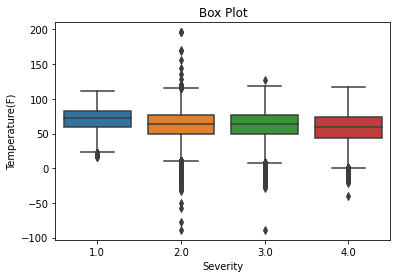

In [12]:
# Create a box plot between the "column_name_1" and "column_name_2" columns
sns.boxplot(x="Severity",y="Temperature(F)",data=US_Accidents_Temperature_vs_Severity)
plt.title("Box Plot")
plt.show()

#### Insight : 

1 has highest median, and 4 has the least meadian.

This means that less severe accidents tend to occur during higher temperatures

This makes sense, as less temperature in US could mean factors like Black Ice and Snow, that do increase the tendency of more severe accidents

That being said, 2 does seem to have a lot of outliers in which a lot of accidents have happened at both extremely high (>120 F) and low temperatures (< 0 F). Accidents in high temperatures can happen due to factors like fatigue, but they seem to be not as severe

# Data Preparation (for Machine Learning)

We will predict severity of accident based on other columns as independent variables, and we need to prepare data accordingly

### Missing Data

In [13]:
from pyspark.sql.functions import isnull, when, count

US_Accidents_null_count = US_Accidents.select(*[count(when(isnull(c), c)).alias(c) for c in US_Accidents.columns]).toPandas()
US_Accidents_null_count_transposed = US_Accidents_null_count.melt(var_name='column', value_name='null_count')
US_Accidents_null_count_transposed['null_perc'] = US_Accidents_null_count_transposed['null_count']/US_Accidents.count()*100
US_Accidents_null_count_transposed[US_Accidents_null_count_transposed['null_count']!=0].sort_values("null_perc",ascending=False)

,column,null_count,null_perc
10,Number,1743911,61.290031
28,Precipitation(in),549458,19.310789
22,Wind_Chill(F),469643,16.505678
27,Wind_Speed(mph),157944,5.550967
26,Wind_Direction,73775,2.592834
23,Humidity(%),73092,2.568830
29,Weather_Condition,70636,2.482514
25,Visibility(mi),70546,2.479350
21,Temperature(F),69274,2.434646
24,Pressure(in),59200,2.080593


Based from above, Number has 61% nulls, and thus it's best to drop this column altogether. 

Other columns with nulls are at a null maximum % of 20, so we can maybe try removing all rows with even 1 null cell

In [14]:
US_Accidents = US_Accidents.drop('Number').dropna(how='any')

In [15]:
US_Accidents = US_Accidents.dropna(how='any')

In [16]:
US_Accidents.count()

2207325

In [17]:
(2845342 - 2207325)/2845342*100

22.42320958253876

Thus, we have dropped 22% of our rows since they had atleast 1 null value. We are still left with a huge amount of data (2.2 million)

## Feature Engineering

### Drop Unrequired columns

As mentioned above, we have 47 columns, and below groups :

1) Extent of accident - 'Severity'

2) Accident Time - 'Start_Time', 'End_Time' , 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'Timezone'

3) Location Details - 'Start_Lat', 'Start_Lng','End_Lat', 'End_Lng', 'Distance(mi)', 'Street', 'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Airport_Code','Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',

4) Weather - 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition'

5) Text Description - 'Description'

6) ID - ID

Now we need to decide which columns to keep, what features to create, and which to remove. 

##### To drop :

*) ID - it is a row identifier and provides no value to an ML model

*) Description - we are not implementing NLP for Text Mining (it's future scope for sure)

*) Country - since all have the same values, it has no value in an ML Model

*) Weather_Timestamp - it seems not as necessary

*) Zipcode - no valuedoesn't relate linearly with Severity of accident

##### To create :

*) Accident duration = End_Time - Start_Time

##### To transform :

*) Start_Time : Get hours and Month, delete the column

*) End_Time : Get hours and month, delete the column

To note - End_time is the time at which the road is reopened for public use after an accident has occured. Thus Accident Duration is the amount of time the road is blocked due to accident

In [18]:
# Drop

US_Accidents = US_Accidents.drop(*['ID','Description','Country','Weather_Timestamp','Zipcode'])

In [19]:
# Create

from pyspark.sql.functions import expr

US_Accidents = US_Accidents.withColumn("Accident_duration", expr("floor((unix_timestamp(End_Time, 'yyyy-MM-dd HH:mm:ss') - unix_timestamp(Start_Time, 'yyyy-MM-dd HH:mm:ss')) / 3600)"))
US_Accidents = US_Accidents.drop('End_Time')

In [20]:
# Transform

US_Accidents = US_Accidents.withColumn('Start_hour', date_format('Start_Time', 'HH'))
US_Accidents = US_Accidents.withColumn('Month', date_format('Start_Time', 'MM'))
US_Accidents = US_Accidents.withColumn('year', date_format('Start_Time', 'yyyy')).drop('Start_Time')

In [21]:
display_spark_df(US_Accidents)

   Severity           Start_Lat           Start_Lng    End_Lat     End_Lng  \
0       3.0  40.108909999999995           -83.09286   40.11206   -83.03187   
1       3.0           39.172393  -84.49279200000002  39.170476  -84.501798   
2       2.0            41.37531  -81.82016999999998   41.36786   -81.82174   
3       2.0            40.10931           -82.96849   40.11078     -82.984   
4       2.0            39.19288           -84.47723   39.19615   -84.47335   

  Distance(mi)       Street Side         City    County  ... Traffic_Signal  \
0         3.23  Outerbelt E    R       Dublin  Franklin  ...          False   
1          0.5       I-75 S    R   Cincinnati  Hamilton  ...          False   
2        0.521       I-71 S    R    Cleveland  Cuyahoga  ...          False   
3        0.826  Outerbelt W    R  Westerville  Franklin  ...          False   
4        0.307       I-75 N    R   Cincinnati  Hamilton  ...          False   

  Turning_Loop Sunrise_Sunset  Civil_Twilight Nautical_T

## Converting Categorical to Numeric Variables

In [22]:
def is_column_float(df, col):
    try:
        float(df.first()[col])
        return True
    except:
        return False

# get the list of columns that can be converted to integers
float_columns = []
for col in US_Accidents.columns:
    if is_column_float(US_Accidents, col):
        float_columns.append(col)

print("Columns that can be converted to floats:", float_columns)

Columns that can be converted to floats: ['Severity', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Start_hour', 'Accident_duration', 'Month', 'year']


In [23]:
string_columns = list(set(US_Accidents.columns) - set(float_columns))
print(string_columns)

['Bump', 'Turning_Loop', 'No_Exit', 'Airport_Code', 'Timezone', 'Junction', 'Stop', 'Traffic_Calming', 'Sunrise_Sunset', 'Nautical_Twilight', 'Astronomical_Twilight', 'State', 'Amenity', 'Crossing', 'Traffic_Signal', 'Station', 'Roundabout', 'Weather_Condition', 'Side', 'Civil_Twilight', 'Give_Way', 'Wind_Direction', 'County', 'City', 'Railway', 'Street']


### Can run ML from here

In [58]:
# Convert columns to int

US_Accidents_ML = US_Accidents

for col in float_columns:
    US_Accidents_ML = US_Accidents_ML.withColumn(col, US_Accidents_ML[col].cast("float"))

In [59]:
from pyspark.sql import functions as F

from pyspark.ml.feature import StringIndexer, OneHotEncoder

for col in string_columns:

    stringIndexer = StringIndexer(inputCol=col, outputCol=col+"_num").fit(US_Accidents_ML)
    US_Accidents_ML = stringIndexer.transform(US_Accidents_ML)
    US_Accidents_ML = US_Accidents_ML.drop(col)
    
    if US_Accidents_ML.select(col+"_num").distinct().count()>2:
        US_Accidents_ML = US_Accidents_ML.drop(col+"_num")    

### ML Modelling

We split the model in 80:20 train:test ratio and in a stratified manner - equal proportion of severity classes 1,2,3,4 in bith training and testing data

In [60]:
US_Accidents_1 = US_Accidents_ML.filter(US_Accidents_ML['Severity'] == 1).randomSplit(weights = [0.80, 0.20], seed=0)
US_Accidents_2 = US_Accidents_ML.filter(US_Accidents_ML['Severity'] == 2).randomSplit(weights = [0.80, 0.20], seed=0)
US_Accidents_3 = US_Accidents_ML.filter(US_Accidents_ML['Severity'] == 3).randomSplit(weights = [0.80, 0.20], seed=0)
US_Accidents_4 = US_Accidents_ML.filter(US_Accidents_ML['Severity'] == 4).randomSplit(weights = [0.80, 0.20], seed=0)

US_Accidents_train = US_Accidents_1[0].union(US_Accidents_2[0])
US_Accidents_train = US_Accidents_train.union(US_Accidents_3[0])
US_Accidents_train = US_Accidents_train.union(US_Accidents_4[0])

US_Accidents_test = US_Accidents_1[1].union(US_Accidents_2[1])
US_Accidents_test = US_Accidents_test.union(US_Accidents_3[1])
US_Accidents_test = US_Accidents_test.union(US_Accidents_4[1])

In [61]:
#US_Accidents_train = US_Accidents_train.drop('year').fillna(0)
#US_Accidents_test = US_Accidents_test.drop('year').fillna(0)

In [62]:
from pyspark.ml.feature import VectorAssembler

feature_list = US_Accidents_train.columns
feature_list.remove('Severity') 
print(feature_list)

['Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Start_hour', 'Accident_duration', 'Month', 'year', 'Bump_num', 'Turning_Loop_num', 'No_Exit_num', 'Junction_num', 'Stop_num', 'Traffic_Calming_num', 'Sunrise_Sunset_num', 'Nautical_Twilight_num', 'Astronomical_Twilight_num', 'Amenity_num', 'Crossing_num', 'Traffic_Signal_num', 'Station_num', 'Roundabout_num', 'Side_num', 'Civil_Twilight_num', 'Give_Way_num', 'Railway_num']


In [63]:
# Transform the data from multiple features columns to a single vector of all these columns as required by Spark ML
assembler = VectorAssembler(inputCols=feature_list, outputCol="Feature_Columns")
US_Accidents_train = assembler.transform(US_Accidents_train)
US_Accidents_test = assembler.transform(US_Accidents_test)

In [64]:
US_Accidents_train = US_Accidents_train['Feature_Columns','Severity']
US_Accidents_test = US_Accidents_test['Feature_Columns','Severity']

In [65]:
# Hardware setting that blocks program error

spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

DataFrame[key: string, value: string]

### Classification 

#### Decision Tree

In [66]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(labelCol="Severity", featuresCol="Feature_Columns")
dt_model = dt.fit(US_Accidents_train)

In [67]:
# Evaluate the model
results = dt_model.transform(US_Accidents_test)

In [68]:
y_true_train = US_Accidents_train.select(['Severity']).collect()
y_pred_train = dt_model.transform(US_Accidents_train).select(['prediction']).collect()

In [69]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_true_train,y_pred_train))

              precision    recall  f1-score   support

         1.0       0.52      0.04      0.08     18952
         2.0       0.95      0.99      0.97   1645479
         3.0       0.45      0.38      0.41     51799
         4.0       0.56      0.02      0.04     49625

    accuracy                           0.93   1765855
   macro avg       0.62      0.36      0.37   1765855
weighted avg       0.92      0.93      0.92   1765855



In [70]:
y_true = results.select(['Severity']).collect()
y_pred = results.select(['prediction']).collect()

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         1.0       0.53      0.04      0.07      4604
         2.0       0.95      0.99      0.97    411596
         3.0       0.46      0.39      0.42     12789
         4.0       0.56      0.02      0.04     12481

    accuracy                           0.94    441470
   macro avg       0.62      0.36      0.38    441470
weighted avg       0.92      0.94      0.92    441470



In [71]:
# Print the feature importances
print(importances)

(34,[0,1,2,3,4,13,15,30],[0.06090298414593028,0.19309849970897616,0.03984844289815273,0.04295784454092998,0.021601775085762952,0.2943361478101768,0.3457472278486246,0.0015070779614463445])


In [95]:
# Get the feature importances
importances = dt_model.featureImportances

importances_df = pd.DataFrame({"Feature": US_Accidents_ML.columns[1:],"Importance":importances.toArray()*100})
importances_df = importances_df.sort_values('Importance',ascending=False)
importances_df

,Feature,Importance
15,year,34.574723
13,Accident_duration,29.433615
1,Start_Lng,19.309850
0,Start_Lat,6.090298
3,End_Lng,4.295784
2,End_Lat,3.984844
4,Distance(mi),2.160178
30,Side_num,0.150708
25,Amenity_num,0.000000
22,Sunrise_Sunset_num,0.000000


#### Random Forest

In [40]:
from pyspark.ml.classification import RandomForestClassifier

# Select the ML algorithm
rf = RandomForestClassifier(labelCol="Severity", featuresCol="Feature_Columns")
rf_model = rf.fit(US_Accidents_train)

In [41]:
# Evaluate the model
results = rf_model.transform(US_Accidents_test)

In [42]:
y_true = results.select(['Severity']).collect()
y_pred = results.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00      4604
         2.0       0.93      1.00      0.97    411596
         3.0       1.00      0.00      0.01     12789
         4.0       0.00      0.00      0.00     12481

    accuracy                           0.93    441470
   macro avg       0.48      0.25      0.24    441470
weighted avg       0.90      0.93      0.90    441470



In [43]:
print(confusion_matrix(y_true, y_pred))

[[     0   4604      0      0]
 [     0 411596      0      0]
 [     0  12754     35      0]
 [     0  12481      0      0]]


In [96]:
# Get the feature importances
importances = rf_model.featureImportances

importances_df = pd.DataFrame({"Feature": US_Accidents_ML.columns[1:],"Importance":importances.toArray()*100})
importances_df = importances_df.sort_values('Importance',ascending=False)
importances_df

,Feature,Importance
15,year,20.228990
13,Accident_duration,19.362987
14,Month,16.280788
4,Distance(mi),9.238778
1,Start_Lng,8.063700
3,End_Lng,7.623144
8,Pressure(in),4.566789
2,End_Lat,4.407640
0,Start_Lat,4.118971
27,Traffic_Signal_num,2.015521


#### Logistic Regression

In [45]:
from pyspark.ml.classification import LogisticRegression
# Select the ML algorithm
lr = LogisticRegression(labelCol="Severity", featuresCol="Feature_Columns")
lr_model = lr.fit(US_Accidents_train)

In [46]:
# Evaluate the model
results = lr_model.transform(US_Accidents_test)

In [47]:
y_true = results.select(['Severity']).collect()
y_pred = results.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         1.0       0.32      0.01      0.03      4604
         2.0       0.94      0.99      0.96    411596
         3.0       0.26      0.07      0.11     12789
         4.0       0.38      0.02      0.04     12481

    accuracy                           0.93    441470
   macro avg       0.47      0.28      0.29    441470
weighted avg       0.89      0.93      0.90    441470



In [48]:
print(confusion_matrix(y_true, y_pred))

[[    64   4537      2      1]
 [   106 409037   2090    363]
 [    16  11768    904    101]
 [    16  11697    481    287]]
